출처: [https://www.kaggle.com/code/willkoehrsen/tuning-automated-feature-engineering-exploratory/notebook](https://www.kaggle.com/code/willkoehrsen/tuning-automated-feature-engineering-exploratory/notebook)

# Introduction: Tuning Automated Feature Engineering
이 노트북에서는 Home Credit Default Risk competition에 적용된 [basic automated feature engineering](https://choisk7.github.io/kaggle/Automated_Feature_Engineering_Basics/)을 확장할 것입니다. feature 세트를 개선하고 도메인 지식을 최종 데이터 세트에 통합하기 위한 몇 가지 다른 방법을 탐구할 것입니다. 이러한 방법에는 다음과 같은 것이 포함됩니다:

- 적절하게 variable type 나타내기
- time variables를 만들고 사용하기
- variables의 interesting 값 설정하기
- seed features 만들기
- custom primitives 만들기

이 competition에 대한 discussion을 읽고, 일부 최고의 커널을 통해 작업하려면 복잡한 feature engineering이 필수입니다. base 노트북에서 default feature primitives를 사용하면 점수가 향상되었지만, 더 잘하려면 좀 더 고급적인 방법이 필요합니다.

이번 노트북은 featuretools의 기능을 탐구하는 것에 가깝습니다.

In [1]:
import pandas as pd
import numpy as np
import featuretools as ft

import warnings
warnings.filterwarnings("ignore")

## Read in Data and Create Smaller Datasets
automated feature engineering은 많은 계산이 필요한 작업이므로 데이터를 1000행으로 제한합니다. 나중에 이 코드를 함수로 리팩토링(결과의 변경 없이 코드의 구조를 재조정)하고, 스크립트에 넣어 더 강력한 시스템에서 실행할 수 있습니다.

In [2]:
app_train = pd.read_csv('./home_credit/application_train.csv').sort_values('SK_ID_CURR').reset_index().loc[:1000, :].drop(columns=['index'])
app_test = pd.read_csv('./home_credit/application_test.csv').sort_values('SK_ID_CURR').reset_index().loc[:1000, :].drop(columns=['index'])
bureau = pd.read_csv('./home_credit/bureau.csv').sort_values(['SK_ID_CURR', 'SK_ID_BUREAU']).reset_index().loc[:1000, :].drop(columns=['index'])
bureau_balance = pd.read_csv('./home_credit/bureau_balance.csv').sort_values('SK_ID_BUREAU').reset_index().loc[:1000, :].drop(columns=['index'])
cash = pd.read_csv('./home_credit/POS_CASH_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns=['index'])
credit = pd.read_csv('./home_credit/credit_card_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns=['index'])
previous = pd.read_csv('./home_credit/previous_application.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns=['index'])
installments = pd.read_csv('./home_credit/installments_payments.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns=['index'])

# Properly Representing Variable Types
```app``` 데이터 프레임에는 정수로 표시되지만, 실제로는 제한된 수의 features만 사용할 수 있는 discrete variables인 열이 많이 있습니다. 이들 중 일부는 boolean flags(1 또는 0만)이고 두 개의 열은 ordinal(ordered discrete)입니다. 이를 boolean variables로 처리하도록 featuretools에 지시하려면 사전 매핑 {```variable_name```: ```variable_type```}을 사용하여 올바른 데이터 유형을 전달해야 합니다.

In [3]:
import woodwork.logical_types

app_types = {}

for col in app_train:
    if (app_train[col].dtype != "object") and (len(app_train[col].unique()) <= 2):
        app_types[col] = woodwork.logical_types.Boolean
        
print('Number of boolean variables: ', len(app_types))

Number of boolean variables:  33


```app``` 데이터에는 두개의 ordinal variables가 있습니다: 도시가 있는 지역과 없는 지역의 등급

In [4]:
app_types["REGION_RATING_CLIENT"] = woodwork.logical_types.Ordinal
app_types["REGION_RATING_CLIENT_W_CITY"] = woodwork.logical_types.Ordinal

app_test_types = app_types.copy()
del app_test_types["TARGET"]

```previous``` 데이터 또한 두개의 boolean variables가 있습니다

In [5]:
previous_types= {'NFLAG_LAST_APPL_IN_DAY': woodwork.logical_types.Ordinal,
                 'NFLAG_INSURED_ON_APPROVAL': woodwork.logical_types.Ordinal}

# Time Variables
시간이 지남에 따라 행동이 변하기 때문에 시간은 많은 데이터 세트에서 중요한 요소가 될 수 있습니다. 따라서, 우리는 이를 반영하는 feature를 만들고 싶을 것입니다. 예를 들어, 고객이 시간이 지남에 따라 점점 더 많은 대출을 받게 되며 이는 곧 채무 불이행에 대한 지표가 될 수 있습니다.

데이터에 분명한 datetimes는 없지만, 상대적인 time offsets는 있습니다. 모든 time off set은 Home Credit의 현재 application에서 측정되며 월 또는 일 단위로 측정됩니다. 예를 들어, ```bureau```에서 ```DAYS_CREDIT``` 열은 "고객이 현재 신청 전에 Credit Bureau credit을 신청한 날"을 나타냅니다. (Credit Bureau는 Home Credit 이외의 다른 신용 기관을 말합니다). 실제 신청 날짜는 모르지만, 모든 클라이언트에 대해 모든 starting application date가 동일하다고 가정하면, ```MONTHS_BALANCE```를 datetime으로 변환할 수 있습니다. 그런 다음 추세를 찾거나 variable의 가장 최근 값을 식별하는 데 사용할 수 있는 relative time으로 처리할 수 있습니다.

## Replace Outliers
365243으로 기록된 많은 day offsets가 있습니다. discussion을 보면, 다른 사람들은 이 숫자를 ```np.nan```으로 바꿨습니다. 이렇게 하지 않으면 Pandas는 timedelta로 변환할 수 없으며 숫자가 너무 크다는 오류가 발생합니다.

In [6]:
def replace_day_outliers(df):
    for col in df.columns:
        if "DAYS" in col:
            df[col] = df[col].replace({365243: np.nan})
            
    return df

app_train = replace_day_outliers(app_train)
app_test = replace_day_outliers(app_test)
bureau = replace_day_outliers(bureau)
bureau_balance = replace_day_outliers(bureau_balance)
credit = replace_day_outliers(credit)
cash = replace_day_outliers(cash)
previous = replace_day_outliers(previous)
installments = replace_day_outliers(installments)

먼저 임의의 날짜를 설정한 다음 월 단위의 time offset을 Pandas ```timedelta``` object로 변환할 수 있습니다.

In [7]:
start_date = pd.Timestamp("2016-01-01")
start_date

Timestamp('2016-01-01 00:00:00')

In [8]:
bureau[['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']].head()

,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,DAYS_CREDIT_UPDATE
0,-857,-492.0,-553.0,-155
1,-909,-179.0,-877.0,-155
2,-879,-514.0,-544.0,-155
3,-1572,-1329.0,-1328.0,-155
4,-559,902.0,NaN,-6


In [9]:
for col in ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']:
    bureau[col] = pd.to_timedelta(bureau[col], 'D')
    
bureau[['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']].head()

,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,DAYS_CREDIT_UPDATE
0,-857 days,-492 days,-553 days,-155 days
1,-909 days,-179 days,-877 days,-155 days
2,-879 days,-514 days,-544 days,-155 days
3,-1572 days,-1329 days,-1328 days,-155 days
4,-559 days,902 days,NaT,-6 days


이 4개의 칼럼은 다른 offset를 나타냅니다:

- ```DAYS_CREDIT```: 현재 Home Credit 고객이 다른 금융기관에서 대출을 신청하기 전의 일수. 여기서는 이를 신청 날짜, ```bureau_credit_application_date```라고 부르고 이것을 entity의 ```time_index```로 만들 것입니다.

- ```DAYS_CREDIT_ENDDATE```: 고객이 Home Credit에 대출을 신청할 때, 남은 신용 일수. 여기서는 이를 종료 날짜, ```bureau_credit_end_date```라고 부를 것입니다.

- ```DAYS_ENDDATE_FACT```: closed credits의 경우, 현재 Home Credit에서 신청하기 전 다른 금융기관의 신용이 종료된 일수. 여기서는 이를 마감일, ```bureau_credit_close_date```라고 부를 것입니다.

- ```DAYS_CREDIT_UPDATE```: Home Credit에 현재 신청하기 전에 이전 신용에 대한 최신 정보가 도착한 일 수입니다. 이를 업데이트 날짜, ```bureau_credit_update```라고 합니다.


manual feature engineering을 수행하는 경우, ```DAYS_CREDIT```에서 ```DAYS_CREDIT_ENDDATE```를 빼서 계획된 대출 기간(일)을 구하거나 ```DAYS_CREDIT_ENDDATE```를 ```DAYS_ENDDATE_FACT```에서 빼서 고객이 대출을 조기에 상환한 일수를 찾는 것과 같이 새 칼럼을 생성할 수 있습니다. 그러나, 이 노트북에서 우리는 어떤 features도 직접 만들지 않고 featuretools가 우리를 위해 유용한 features을 개발하도록 할 것입니다.

```timedelta```를 통해 칼럼을 만들기 위해, 간단하게 시작 날짜에 offset을 더합니다.

In [10]:
bureau['bureau_credit_application_date'] = start_date + bureau['DAYS_CREDIT']
bureau['bureau_credit_end_date'] = start_date + bureau['DAYS_CREDIT_ENDDATE']
bureau['bureau_credit_close_date'] = start_date + bureau['DAYS_ENDDATE_FACT']
bureau['bureau_credit_update_date'] = start_date + bureau['DAYS_CREDIT_UPDATE']

## Plot for a sanity check
Conversion이 계획대로 진행되었는지 확인하기 위해 대출 기간의 분포를 보여주는 plot을 만들어 보겠습니다.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 26
plt.style.use('fivethirtyeight')

bureau = bureau.drop(columns=['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE'])

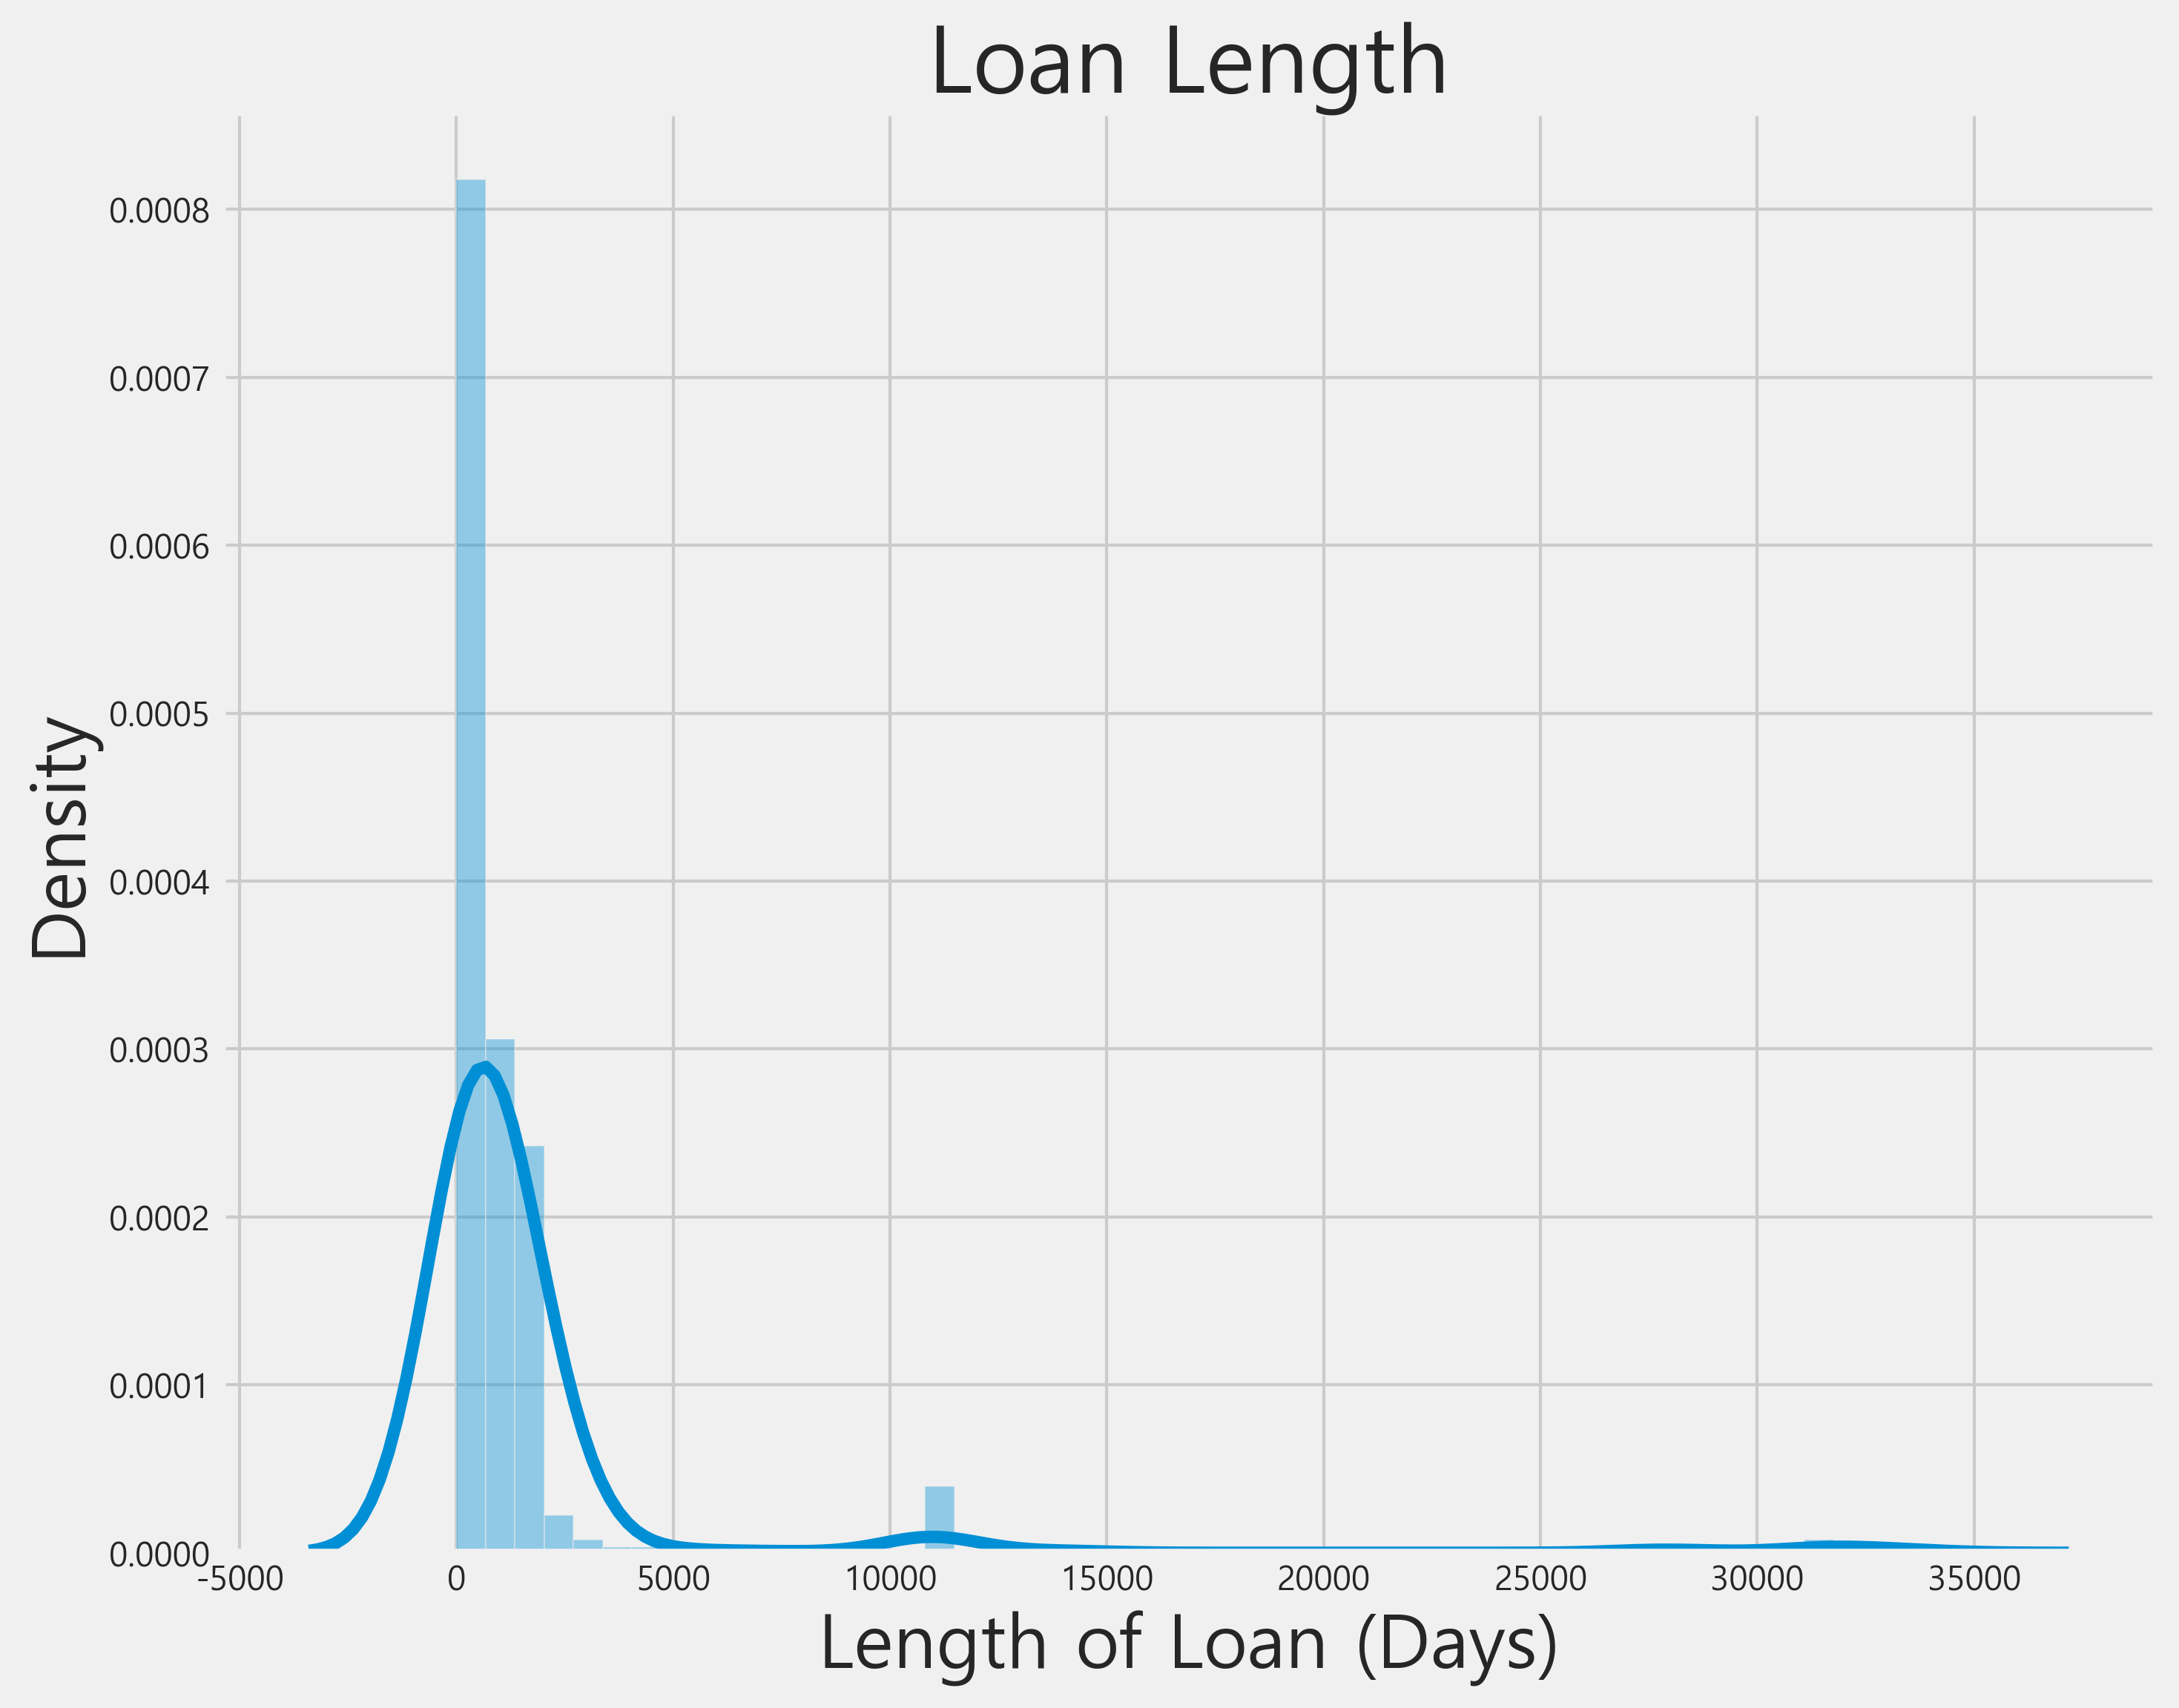

In [12]:
plt.figure(figsize=(10, 8))
sns.distplot((bureau['bureau_credit_end_date'] - bureau['bureau_credit_application_date']).dropna().dt.days);
plt.xlabel('Length of Loan (Days)', size=24); plt.ylabel('Density', size=24); plt.title('Loan Length', size=30);

이상하게 긴 대출이 많은 것 같습니다. discussion을 읽어보면 다른 사람들도 이러한 사실을 파악한 것을 알 수 있습다. 이 시점에서 우리는 이상치를 남겨둘 것입니다. time offset 칼럼도 삭제합니다.

### Bureau Balance
bureau balance 데이터 프레임에는 months offset으로 사용할 수 있는 ```MONTHS_BALANCE``` 칼럼이 있습니다. 이러한 결과로부터 나온 dates 칼럼은 ```time_index```로 사용할 수 있습니다.

Text(0, 0.5, 'Status')

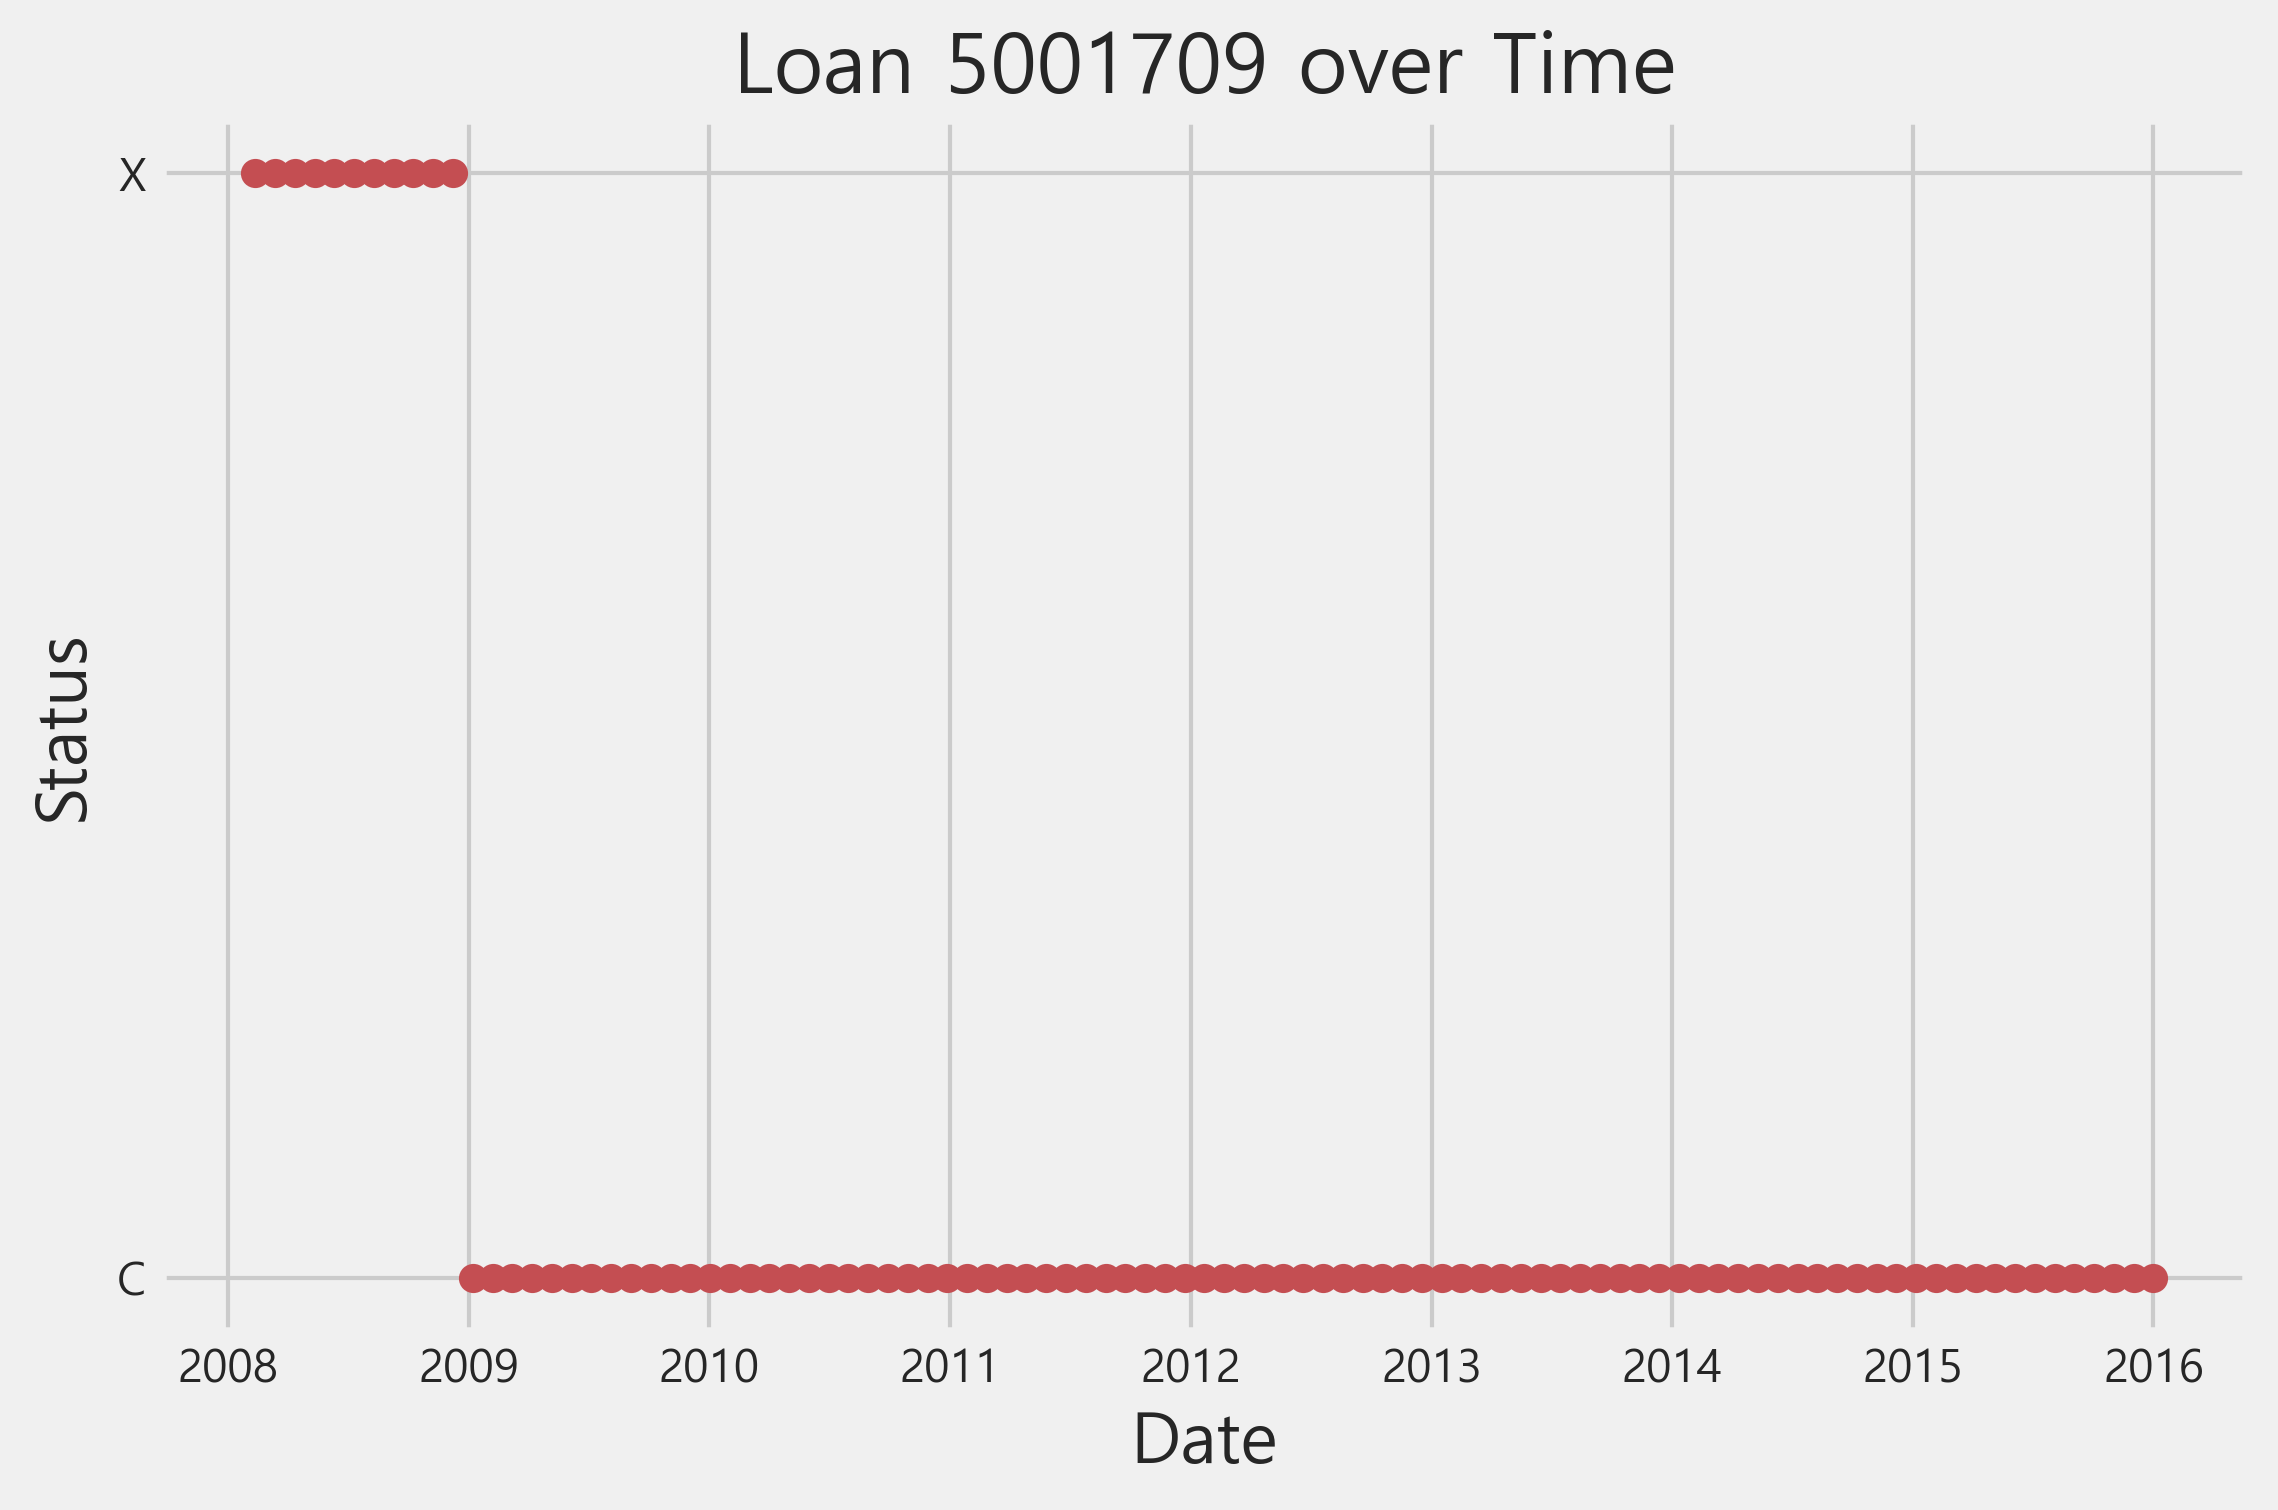

In [13]:
bureau_balance['MONTHS_BALANCE'] = pd.to_timedelta(bureau_balance['MONTHS_BALANCE'] * 30, 'D')

bureau_balance['bureau_balance_date'] = start_date + bureau_balance['MONTHS_BALANCE']
bureau_balance = bureau_balance.drop(columns = ['MONTHS_BALANCE'])

example_credit = bureau_balance[bureau_balance['SK_ID_BUREAU'] == 5001709]
plt.plot(example_credit['bureau_balance_date'], example_credit['STATUS'], 'ro')
plt.title('Loan 5001709 over Time'); plt.xlabel('Date'); plt.ylabel('Status')

### Previous Applications
```previous``` 데이터 프레임은 Home Credit에서 이전 대출 신정 정보를 가지고 있습니다. 이 데이터세트에는 여러 time offset 칼럼이 있습니다.

- ```DAYS_DECISION```: 현재 Home Credit에 대출 신청하기 전, 이전 대출 신청에 대한 결정이 내려진 날짜 수. 이는 데이터의 ```time_index```가 됩니다.

- ```DAYS_FIRST_DRAWING```: Home Credit에서 현재 대출 신청하기 전, 첫 번째 지출이 이루어진 일 수

- ```DAYS_FIRST_DUE```: Home Credit에서 현재 대출 신청하기 전의 첫 번째 만기일 수

- ```DAYS_LAST_DUE_1ST_VERSION```: Home Credit에서 현재 대출 신청하기 전의 첫번째 일수?

- ```DAYS_LAST_DUE```: Home Credit에서 현재 대출 신청 전 이전 대출 신청의 마지막 만기일 수

- ```DAYS_TERMINATION```: 현재 Home Credit에서 대출 신청하기 전의 예상 종료 일수

loop를 통해 이러한 칼럼들을 timedelta로 전환하고, time 칼럼을 만듭니다.

Text(0, 0.5, 'Credit Amount')

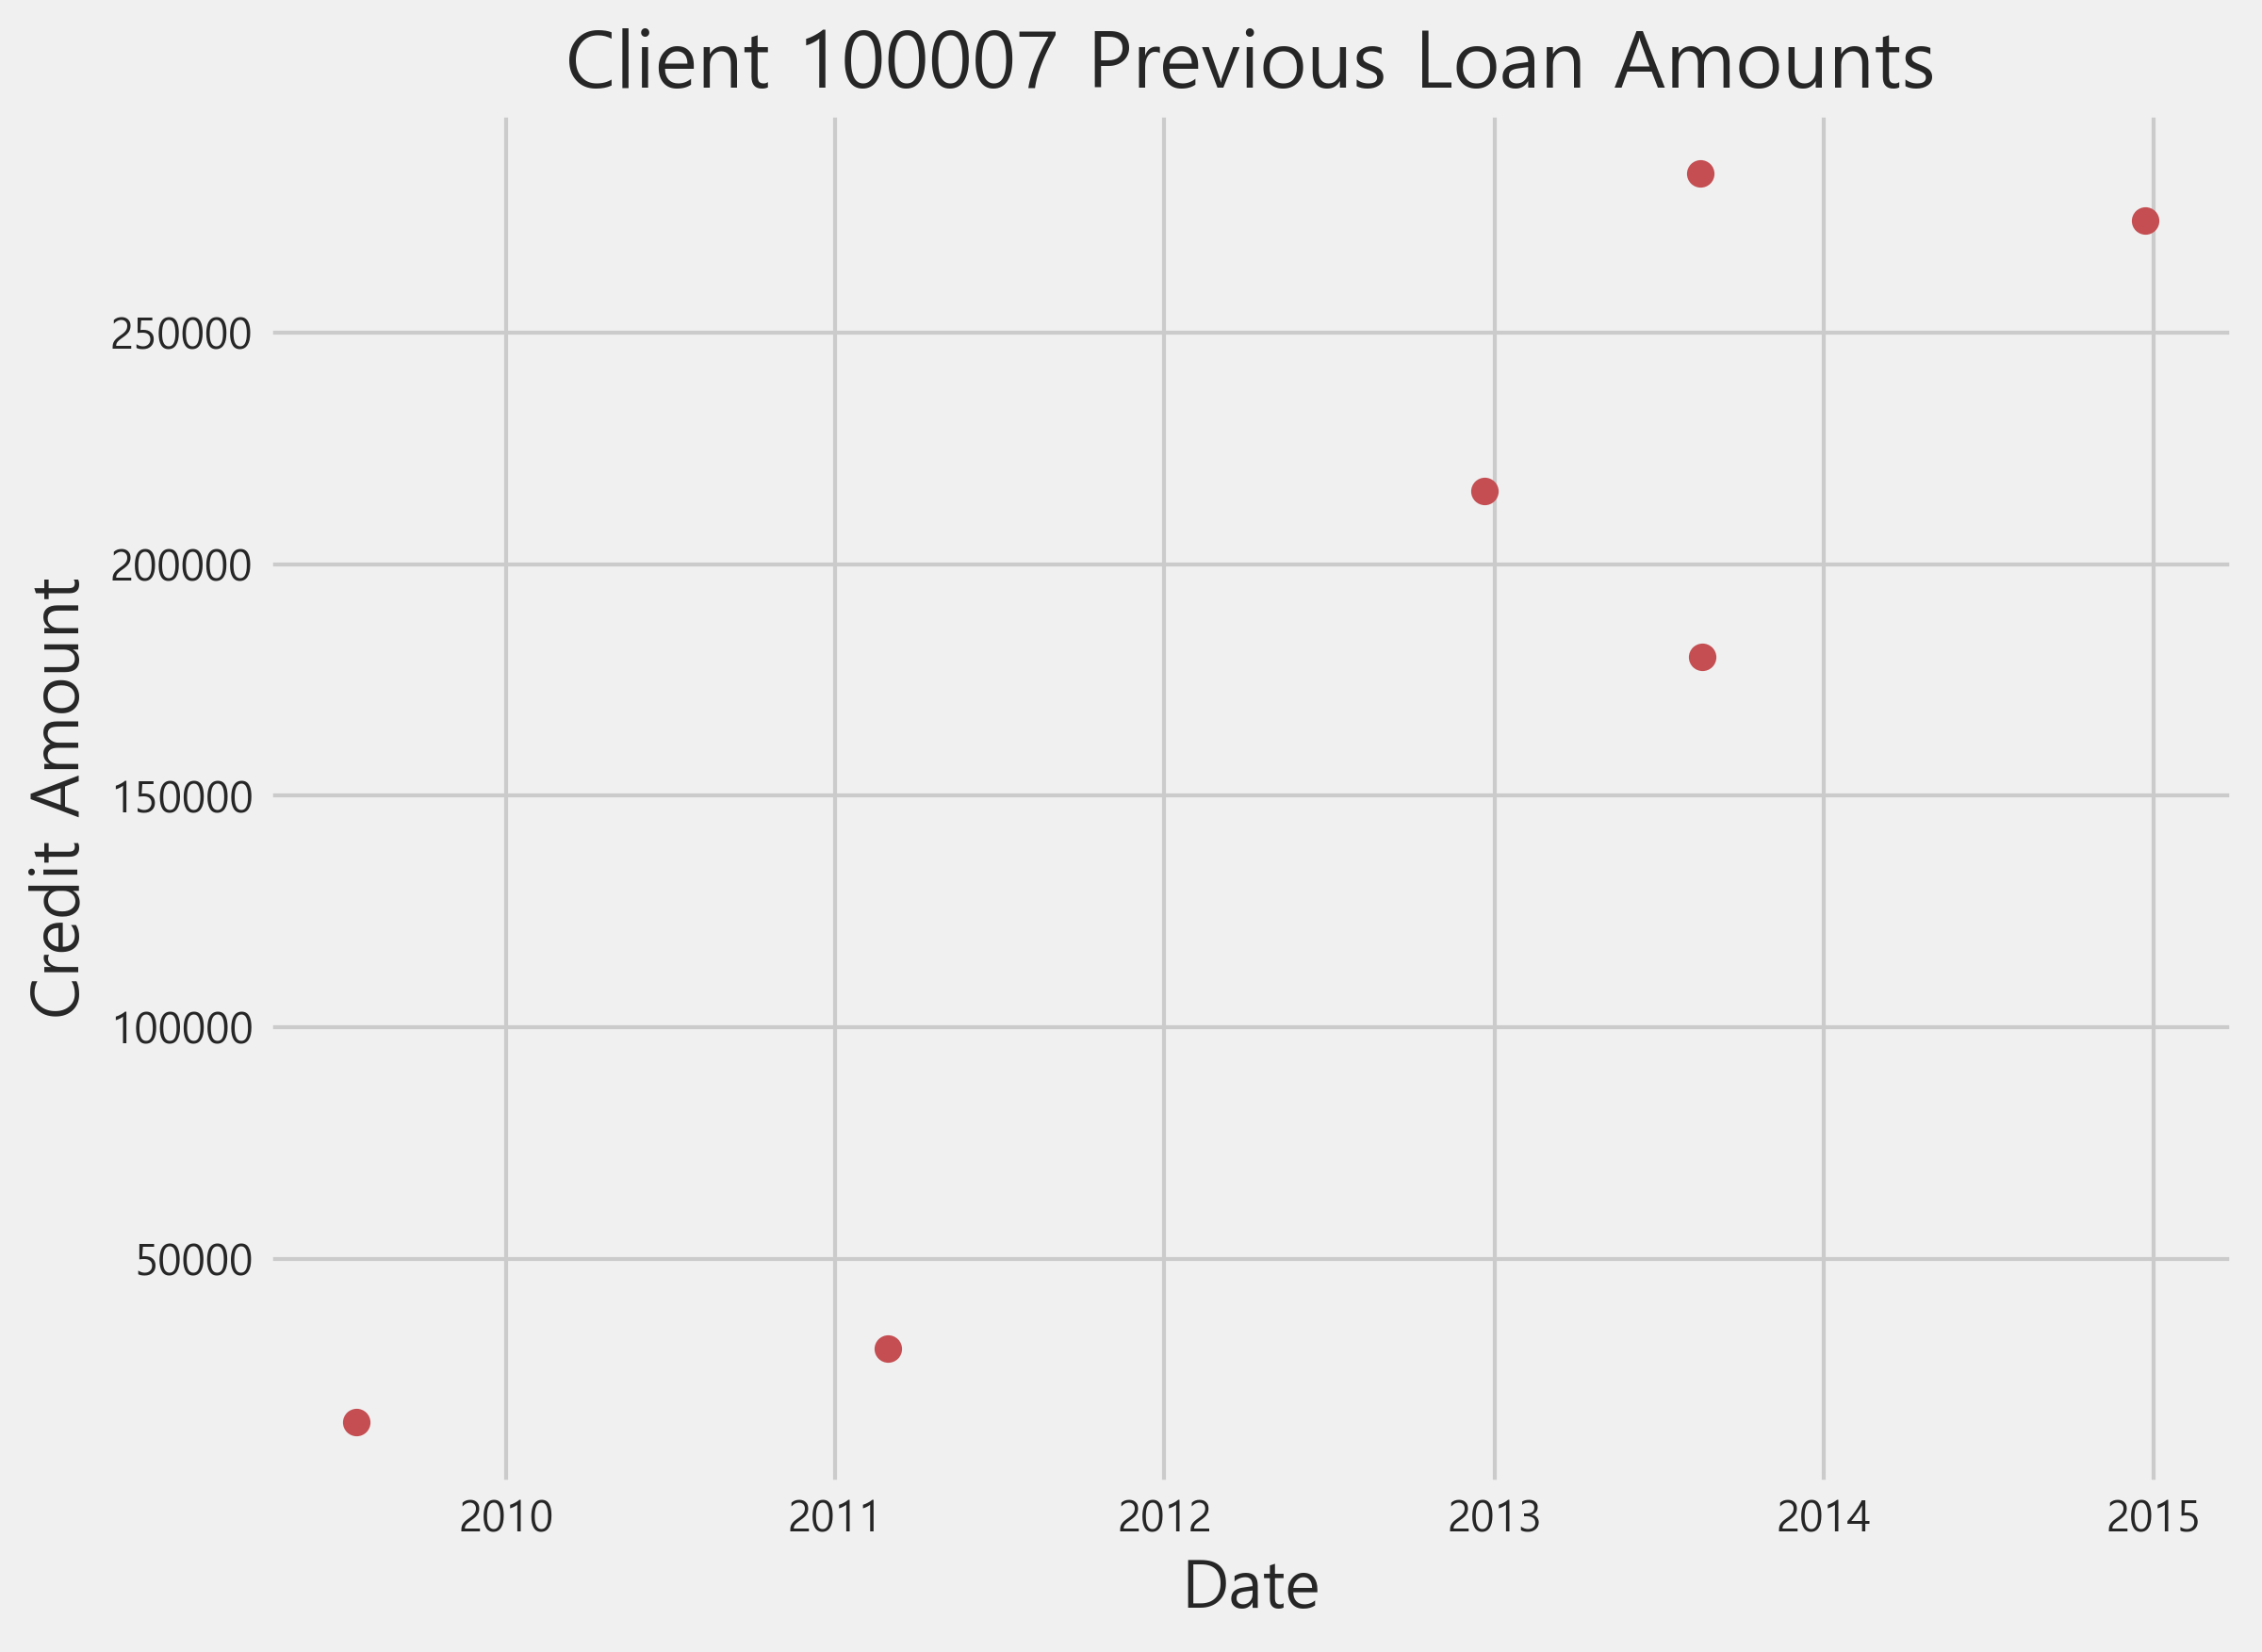

In [14]:
for col in ['DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']:
    previous[col] = pd.to_timedelta(previous[col], "D")
    
previous['previous_decision_date'] = start_date + previous['DAYS_DECISION']
previous['previous_drawing_date'] = start_date + previous['DAYS_FIRST_DRAWING']
previous['previous_first_due_date'] = start_date + previous['DAYS_FIRST_DUE']
previous['previous_last_duefirst_date'] = start_date + previous['DAYS_LAST_DUE_1ST_VERSION']
previous['previous_last_due_date'] = start_date + previous['DAYS_LAST_DUE']
previous['previous_termination_date'] = start_date + previous['DAYS_TERMINATION']

plt.figure(figsize=(8, 6))
example_client = previous[previous["SK_ID_CURR"] == 100007]
plt.plot(example_client["previous_decision_date"], example_client["AMT_CREDIT"], "ro")
plt.title('Client 100007 Previous Loan Amounts'); plt.xlabel('Date'); plt.ylabel('Credit Amount')

### Previous Credit and Cash
```credit_card_balance```와 ```POS_CASH_balance```에는 각각 month offset이 있는 ```MONTHS_BALANCE``` 칼럼이 있습니다. 이 값은 Home Credit에서 이전 신청 기록을 현재 신청하기 전의 개월 수입니다.. 이들은 데이터의 ```time_index```를 나타냅니다.

Text(0, 0.5, 'Contract Status')

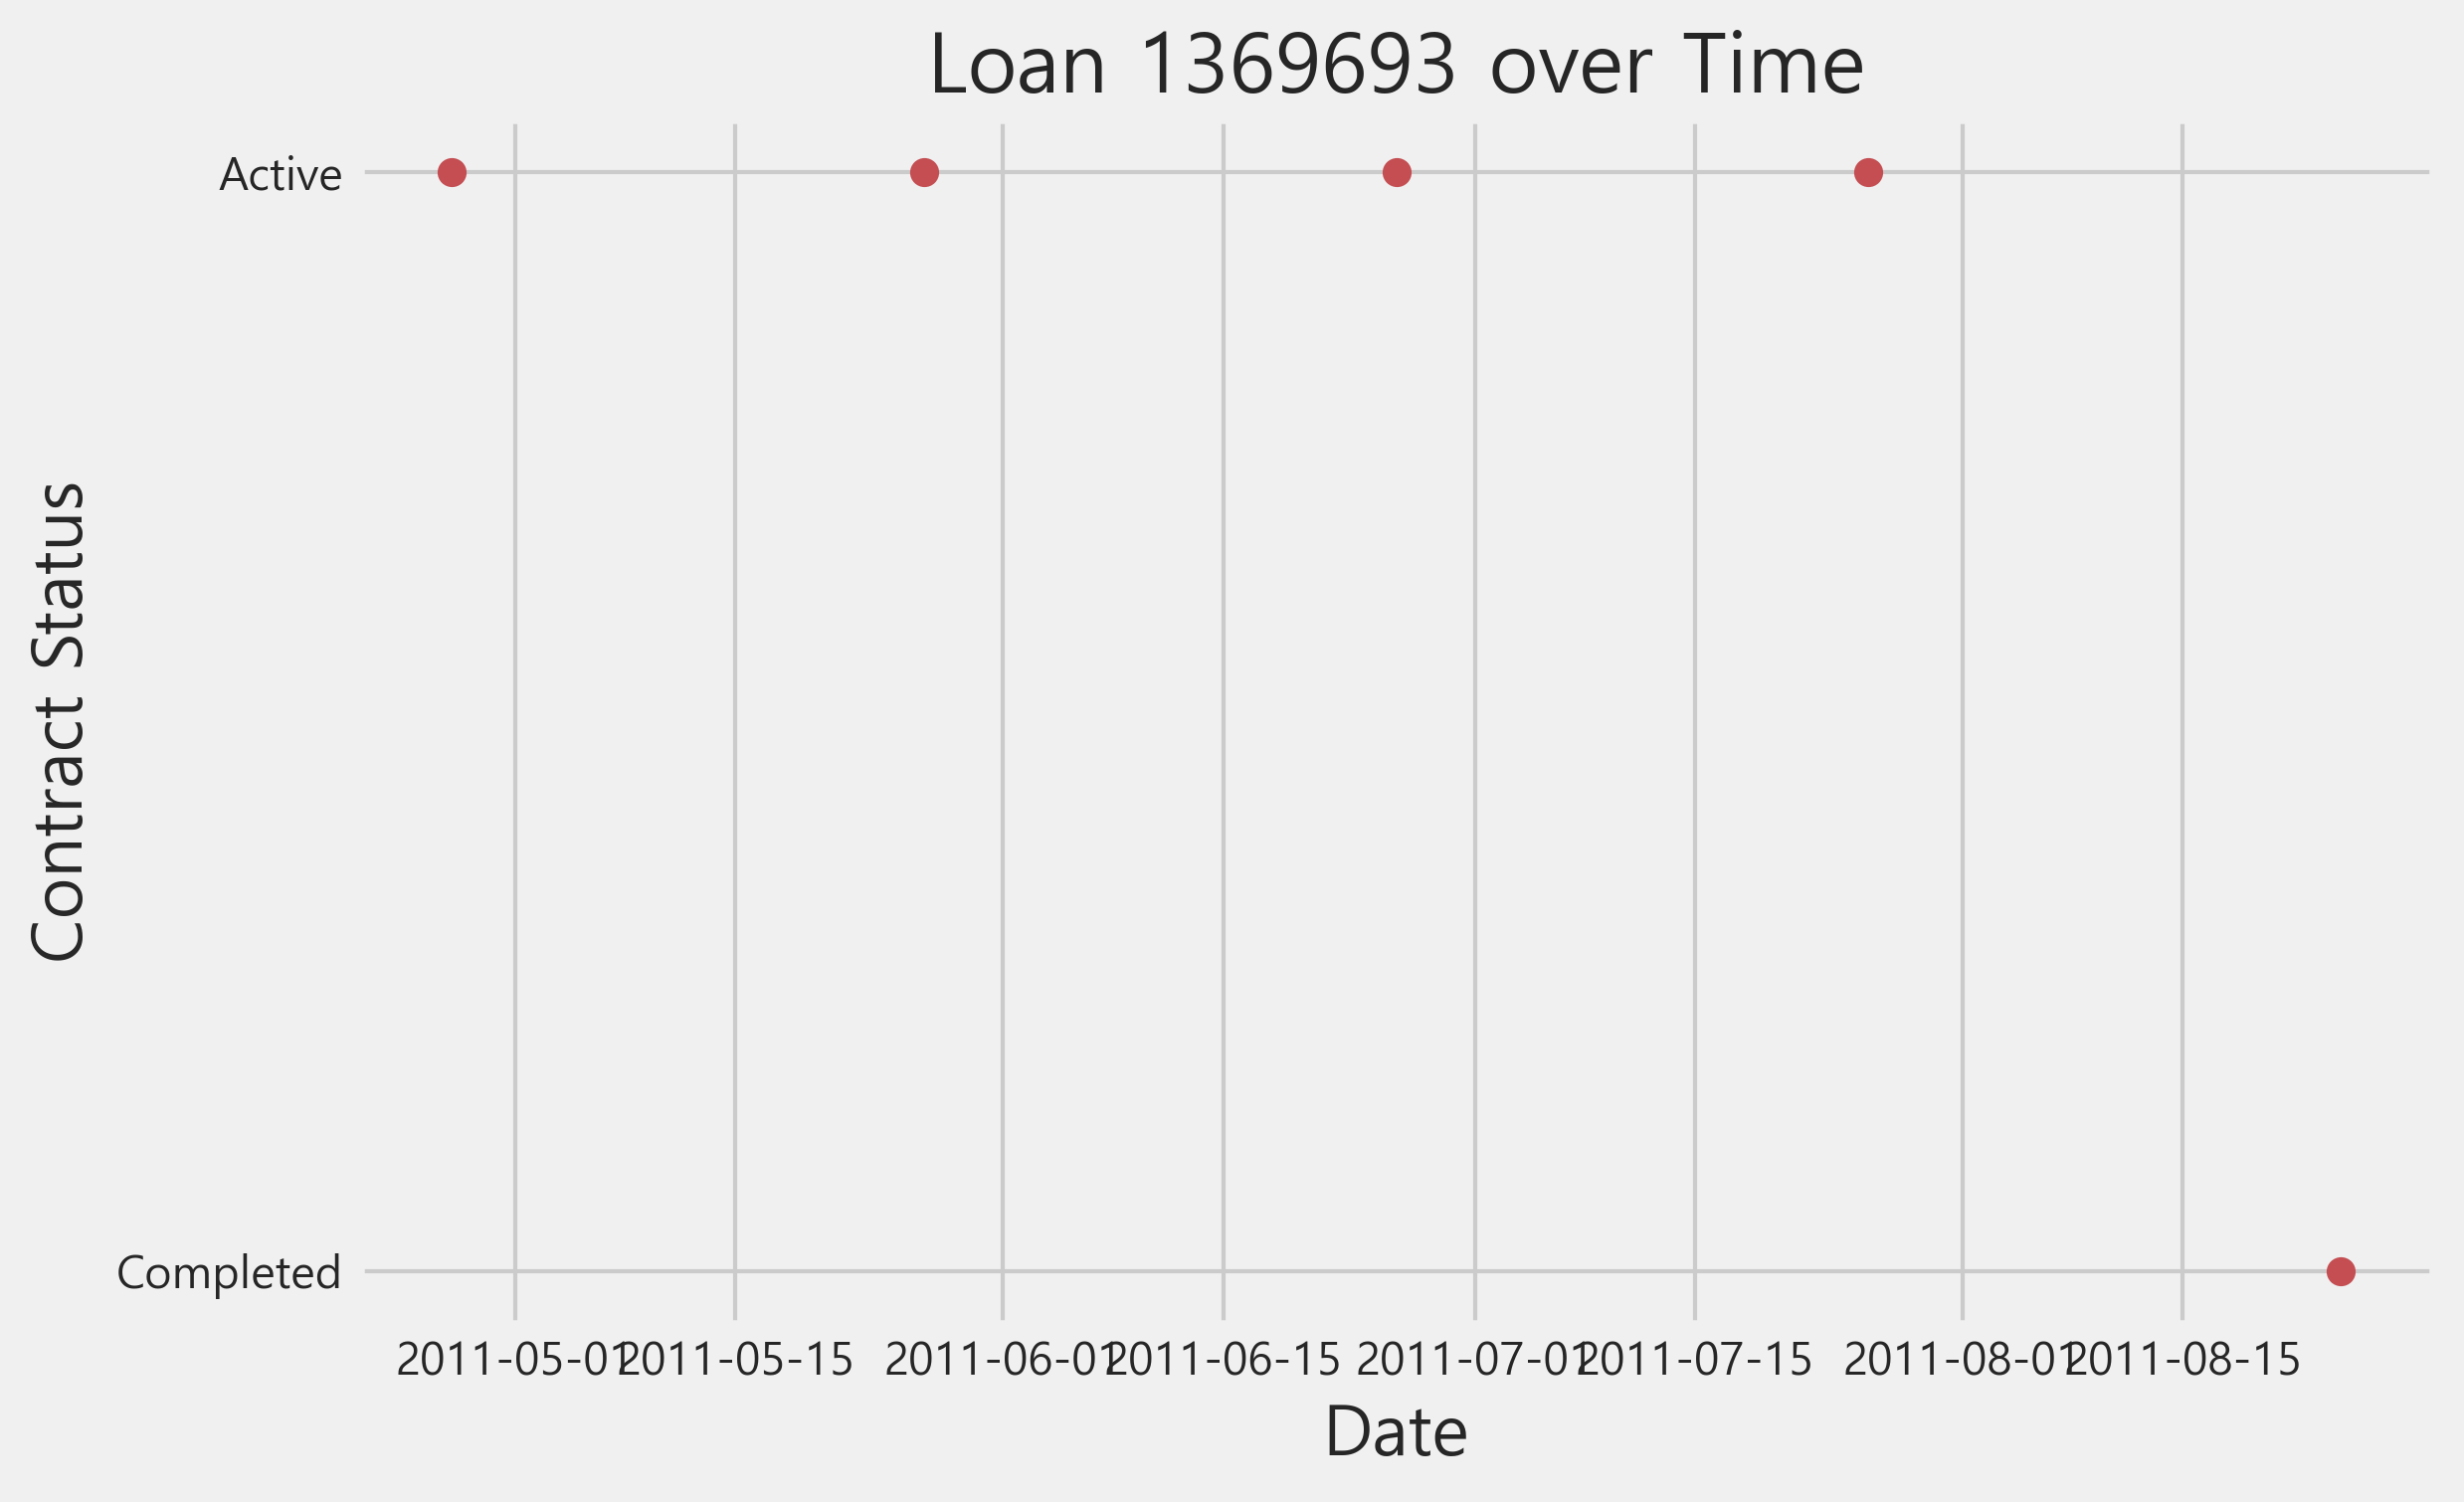

In [15]:
credit['MONTHS_BALANCE'] = pd.to_timedelta(credit['MONTHS_BALANCE'] * 30, 'D')
cash['MONTHS_BALANCE'] = pd.to_timedelta(cash['MONTHS_BALANCE'] * 30, 'D')

credit['credit_balance_date'] = start_date + credit['MONTHS_BALANCE']
credit = credit.drop(columns=['MONTHS_BALANCE'])

cash['cash_balance_date'] = start_date + cash['MONTHS_BALANCE']
cash = cash.drop(columns=['MONTHS_BALANCE'])

example_credit = cash[cash['SK_ID_PREV'] == 1369693]

plt.plot(example_credit['cash_balance_date'], example_credit['NAME_CONTRACT_STATUS'], 'ro')
plt.title('Loan 1369693 over Time'); plt.xlabel('Date'); plt.ylabel('Contract Status')

### Installments Payments
```installments_payments``` 데이터에는 Home Credit에서 이전 대출에 대한 각 지출에 대한 정보가 포함됩니다. 여기에는 두 개의 date offset 칼럼이 있습니다.

- ```DAYS_INSTALMENT```: Home Credit에 현재 대출 신청 전, 이전 할부금이 지불되었던 일 수입니다.
- ```DAYS_ENTRY_PAYMENT```: 홈 크레딧에서 현재 대출 신청 전, 이전 할부금이 실제로 지급된 일 수입니다.

이제 이 프로세스는 익숙할 것입니다. timedelta로 변환한 다음, time 칼럼을 만듭니다. ```DAYS_INSTALMENT```는 time_index로 사용됩니다.

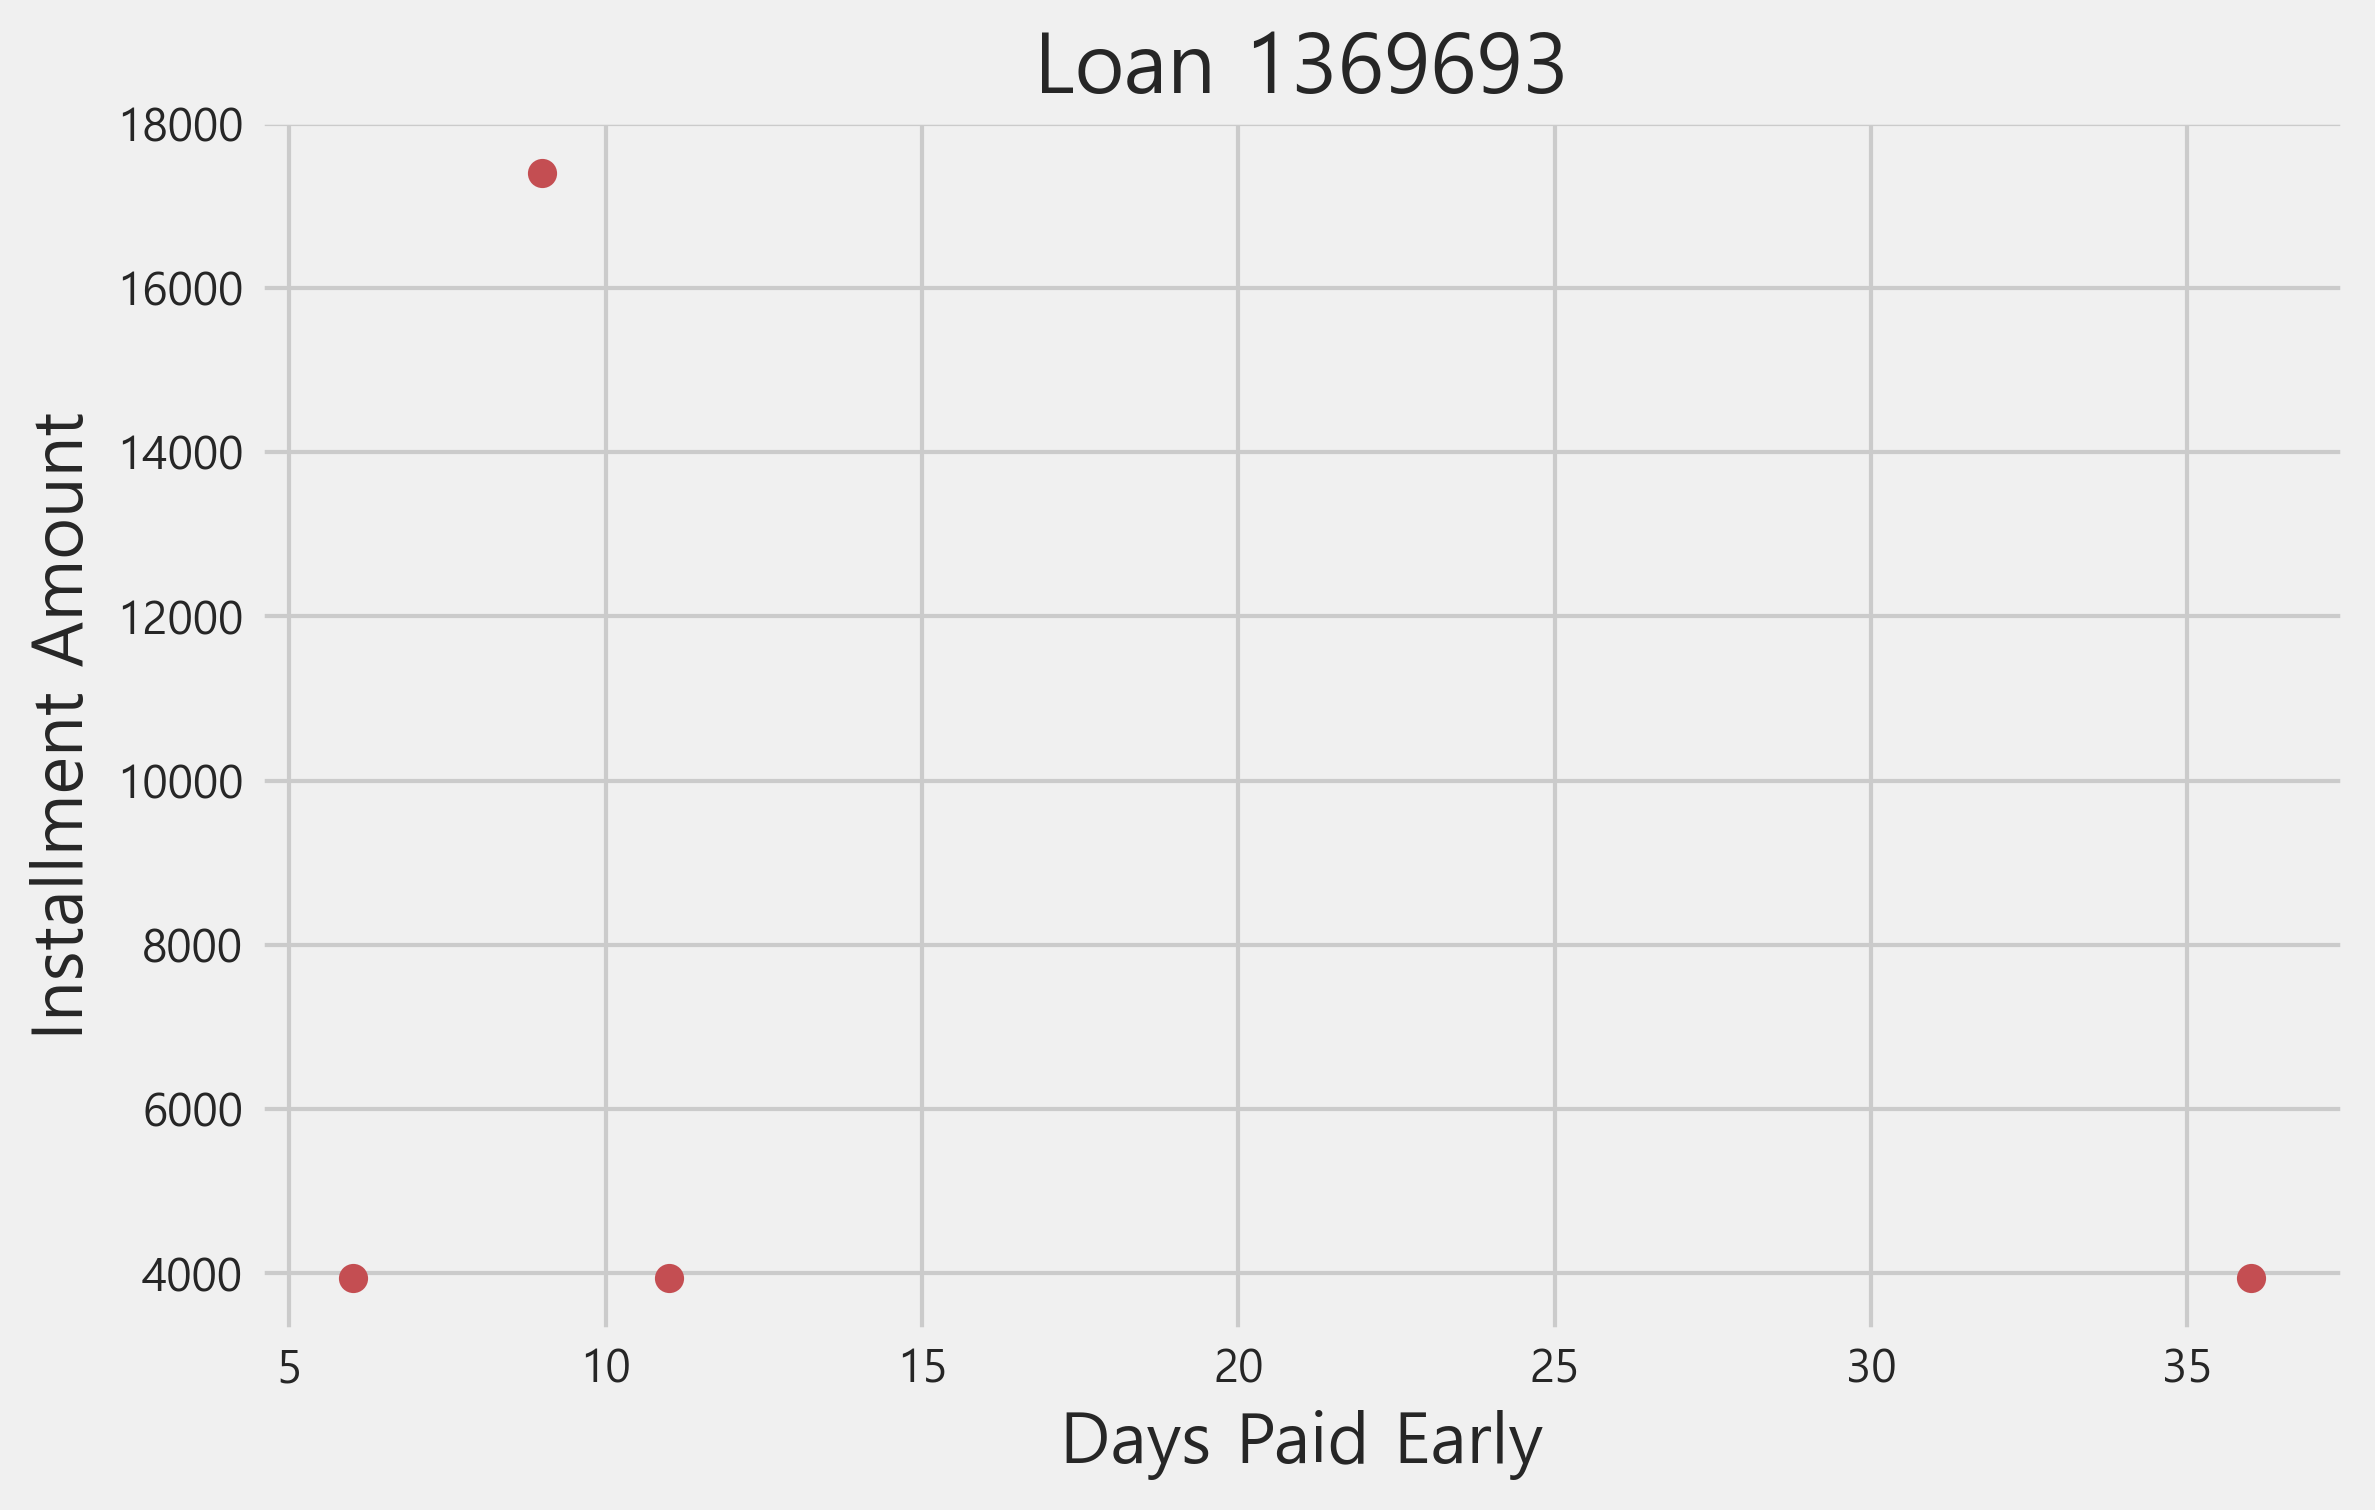

In [16]:
installments['DAYS_INSTALMENT'] = pd.to_timedelta(installments['DAYS_INSTALMENT'], 'D')
installments['DAYS_ENTRY_PAYMENT'] = pd.to_timedelta(installments['DAYS_ENTRY_PAYMENT'], 'D')

installments['installments_due_date'] = start_date + installments['DAYS_INSTALMENT']
installments = installments.drop(columns = ['DAYS_INSTALMENT'])

installments['installments_paid_date'] = start_date + installments['DAYS_ENTRY_PAYMENT']
installments = installments.drop(columns = ['DAYS_ENTRY_PAYMENT'])

example_credit = installments[installments['SK_ID_PREV'] == 1369693]
plt.plot((example_credit['installments_due_date'] - example_credit['installments_paid_date']).dt.days, example_credit['AMT_INSTALMENT'], 'ro');
plt.title('Loan 1369693'); plt.xlabel('Days Paid Early'); plt.ylabel('Installment Amount');

# Applying Featuretools
이제 time 칼럼을 사용하여 features를 만들 수 있습니다. 이전과 마찬가지로 clients라는 entityset을 만들지만, 이제는 사용할 수 있는 time variables가 있습니다.

In [17]:
es = ft.EntitySet(id="clients")

## Entities
entities를 만들 때, 여기서는 ```index```, ```time_index```, ```variable_types```를 지정합니다. (```time_index```와 ```variable_types```는 존재한다면)

In [18]:
# Ordinal로 하면 에러 발생. 따라서, Categorical로 수정
app_types["REGION_RATING_CLIENT"] = woodwork.logical_types.Categorical
app_types["REGION_RATING_CLIENT_W_CITY"] = woodwork.logical_types.Categorical
app_types

{'TARGET': Boolean,
 'FLAG_MOBIL': Boolean,
 'FLAG_EMP_PHONE': Boolean,
 'FLAG_WORK_PHONE': Boolean,
 'FLAG_CONT_MOBILE': Boolean,
 'FLAG_PHONE': Boolean,
 'FLAG_EMAIL': Boolean,
 'REG_REGION_NOT_LIVE_REGION': Boolean,
 'REG_REGION_NOT_WORK_REGION': Boolean,
 'LIVE_REGION_NOT_WORK_REGION': Boolean,
 'REG_CITY_NOT_LIVE_CITY': Boolean,
 'REG_CITY_NOT_WORK_CITY': Boolean,
 'LIVE_CITY_NOT_WORK_CITY': Boolean,
 'FLAG_DOCUMENT_2': Boolean,
 'FLAG_DOCUMENT_3': Boolean,
 'FLAG_DOCUMENT_4': Boolean,
 'FLAG_DOCUMENT_5': Boolean,
 'FLAG_DOCUMENT_6': Boolean,
 'FLAG_DOCUMENT_7': Boolean,
 'FLAG_DOCUMENT_8': Boolean,
 'FLAG_DOCUMENT_9': Boolean,
 'FLAG_DOCUMENT_10': Boolean,
 'FLAG_DOCUMENT_11': Boolean,
 'FLAG_DOCUMENT_12': Boolean,
 'FLAG_DOCUMENT_13': Boolean,
 'FLAG_DOCUMENT_14': Boolean,
 'FLAG_DOCUMENT_15': Boolean,
 'FLAG_DOCUMENT_16': Boolean,
 'FLAG_DOCUMENT_17': Boolean,
 'FLAG_DOCUMENT_18': Boolean,
 'FLAG_DOCUMENT_19': Boolean,
 'FLAG_DOCUMENT_20': Boolean,
 'FLAG_DOCUMENT_21': Boolean,

In [19]:
es = es.add_dataframe(dataframe_name="app_train", dataframe=app_train,
                          index="SK_ID_CURR", logical_types=app_types)

app_test_types["REGION_RATING_CLIENT"] = woodwork.logical_types.Categorical
app_test_types["REGION_RATING_CLIENT_W_CITY"] = woodwork.logical_types.Categorical

es = es.add_dataframe(dataframe_name="app_test", dataframe=app_test,
                      index="SK_ID_CURR", logical_types=app_test_types)

es = es.add_dataframe(dataframe_name="bureau", dataframe=bureau,
                      index="SK_ID_BUREAU", 
                      time_index="bureau_credit_application_date")

In [20]:
previous_types = {i: woodwork.logical_types.Categorical for i, j in previous_types.items()}
previous_types

{'NFLAG_LAST_APPL_IN_DAY': Categorical,
 'NFLAG_INSURED_ON_APPROVAL': Categorical}

In [21]:
es = es.add_dataframe(dataframe_name="previous", dataframe=previous,
                      index="SK_ID_PREV", time_index="previous_decision_date",
                      logical_types=previous_types)

In [22]:
# 위의 칼럼 같이 index 칼럼이 없는 경우
es = es.add_dataframe(dataframe_name="bureau_balance", dataframe=bureau_balance,
                      make_index=True, # 인덱스를 만들고
                      index="bb_index", # 인덱스 이름 지정
                      time_index="bureau_balance_date")

es = es.add_dataframe(dataframe_name="cash", dataframe=cash, make_index=True,
                      index="cash_index", time_index="cash_balance_date")

es = es.add_dataframe(dataframe_name="installments", dataframe=installments,
                      make_index=True, index="installments_index",
                      time_index="installments_paid_date")

es = es.add_dataframe(dataframe_name="credit", dataframe=credit, make_index=True,
                      index="credit_index",
                      time_index="credit_balance_date")

## Relationships
테이블 간의 관계를 생성합니다.

In [23]:
r_app_bureau = ft.Relationship(es, "app_train", "SK_ID_CURR", "bureau", "SK_ID_CURR")
r_test_app_bureau = ft.Relationship(es, "app_test", "SK_ID_CURR", "bureau", "SK_ID_CURR")

r_bureau_balance = ft.Relationship(es, "bureau", "SK_ID_BUREAU", "bureau_balance", "SK_ID_BUREAU")

r_app_previous = ft.Relationship(es, "app_train", "SK_ID_CURR", "previous", "SK_ID_CURR")
r_test_app_previous = ft.Relationship(es, "app_test", "SK_ID_CURR", "previous", "SK_ID_CURR")

r_previous_cash = ft.Relationship(es, "previous", "SK_ID_PREV", "cash", "SK_ID_PREV")
r_previous_installments = ft.Relationship(es, "previous", "SK_ID_PREV", "installments", "SK_ID_PREV")
r_previous_credit = ft.Relationship(es, "previous", "SK_ID_PREV", "credit", "SK_ID_PREV")

es = es.add_relationships(relationships=[r_app_bureau, r_test_app_bureau, 
                                         r_bureau_balance, r_app_previous, 
                                         r_test_app_previous, r_previous_cash, 
                                         r_previous_installments, 
                                         r_previous_credit])

es

Entityset: clients
  DataFrames:
    app_train [Rows: 1001, Columns: 122]
    app_test [Rows: 1001, Columns: 121]
    bureau [Rows: 1001, Columns: 17]
    previous [Rows: 1001, Columns: 43]
    bureau_balance [Rows: 1001, Columns: 4]
    cash [Rows: 1001, Columns: 9]
    installments [Rows: 1001, Columns: 9]
    credit [Rows: 1001, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app_train.SK_ID_CURR
    bureau.SK_ID_CURR -> app_test.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app_train.SK_ID_CURR
    previous.SK_ID_CURR -> app_test.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

## Time Features
새로운 time variables에서 만들 수 있는 몇 가지 time  features를 살펴보겠습니다. 이러한 시간은 절대적인게 아니라 상대적이기 때문에 추세 또는 누적 합계와 같이 시간 경과에 따른 변화를 보여주는 값에만 관심이 있습니다. 임의의 시작 날짜를 선택하기 때문에 연도 또는 월과 같은 값을 계산하지 않을 것입니다.

이 노트북 전체에서 우리는 행의 수(정수인 경우) 또는 각 chunk에서 사용할 행의 비율(float인 경우)을 지정하는 ```dfs``` 호출에 ```chunk_size```를 전달할 것입니다. 이는 ```dfs``` procedure를 최적화하는 데 도움이 될 수 있으며, ```chunk_size```는 런타임에 상당한 영향을 미칠 수 있습니다. 여기에서는 모든 결과가 한 번에 계산되도록 데이터의 행 수와 동일한 chunk size를 사용합니다. 또한 테스트 데이터로 features를 만드는 것을 피하기 위해 ```ignore_entities = [app_test]```를 전달합니다.

In [40]:
time_features, time_feature_names = ft.dfs(entityset=es, target_dataframe_name='app_train', 
                                           trans_primitives=['cum_sum', 'time_since_previous'], max_depth=2,
                                           agg_primitives=[], verbose=True,
                                           chunk_size=len(app_train),
                                           ignore_dataframes=['app_test'])

Built 191 features
Elapsed: 00:00 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [41]:
time_features.iloc[:, -10:].head()

,CUM_SUM(OBS_60_CNT_SOCIAL_CIRCLE),CUM_SUM(OWN_CAR_AGE),CUM_SUM(REGION_POPULATION_RELATIVE),CUM_SUM(TOTALAREA_MODE),CUM_SUM(YEARS_BEGINEXPLUATATION_AVG),CUM_SUM(YEARS_BEGINEXPLUATATION_MEDI),CUM_SUM(YEARS_BEGINEXPLUATATION_MODE),CUM_SUM(YEARS_BUILD_AVG),CUM_SUM(YEARS_BUILD_MEDI),CUM_SUM(YEARS_BUILD_MODE)
SK_ID_CURR,,,,,,,,,,
100002,2.0,NaN,0.018801,0.0149,0.9722,0.9722,0.9722,0.6192,0.6243,0.6341
100003,3.0,NaN,0.022342,0.0863,1.9573,1.9573,1.9573,1.4152,1.4230,1.4381
100004,3.0,NaN,0.032374,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100006,5.0,NaN,0.040393,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100007,5.0,NaN,0.069056,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
time_feature_names[-10:]

[<Feature: CUM_SUM(OBS_60_CNT_SOCIAL_CIRCLE)>,
 <Feature: CUM_SUM(OWN_CAR_AGE)>,
 <Feature: CUM_SUM(REGION_POPULATION_RELATIVE)>,
 <Feature: CUM_SUM(TOTALAREA_MODE)>,
 <Feature: CUM_SUM(YEARS_BEGINEXPLUATATION_AVG)>,
 <Feature: CUM_SUM(YEARS_BEGINEXPLUATATION_MEDI)>,
 <Feature: CUM_SUM(YEARS_BEGINEXPLUATATION_MODE)>,
 <Feature: CUM_SUM(YEARS_BUILD_AVG)>,
 <Feature: CUM_SUM(YEARS_BUILD_MEDI)>,
 <Feature: CUM_SUM(YEARS_BUILD_MODE)>]

원문과 다르게 ```agg_primitives=[trend]```를 하면 에러가 나기 때문에 ```agg_primitives```를 비워둔채 다음으로 넘어갑니다.

# Interesting Values
featuretools에서 사용할 수 있는 다른 method는 "interesting values"입니다. interesting values를 지정하면 기존 features의 값에 따라 새 features가 계산됩니다. 예를 들어, ```previous``` 데이터 프레임의 ```NAME_CONTRACT_STATUS``` 값을 조건으로 하는 새 feature을 만들 수 있습니다. 각 stat은 데이터에서 더 중요한 특정 지표가 있다는 것을 알 때, 유용할 수 있는 지정된 interesting values에 대해 계산합니다.

In [43]:
previous['NAME_CONTRACT_STATUS'].value_counts()

Approved        594
Refused         206
Canceled        186
Unused offer     15
Name: NAME_CONTRACT_STATUS, dtype: int64

interesting values를 사용하기 위해 variable에 할당한 다음 ```dfs``` 호출에서 ```where_primitives```를 지정합니다.

In [45]:
es['previous']['NAME_CONTRACT_STATUS'].interesting_values=['Approved', 'Refused', 'Canceled']

interesting_features, interesting_feature_names = ft.dfs(entityset=es,
                                                         target_dataframe_name="app_train",
                                                         max_depth=1,
                                                         where_primitives=["mean", "mode"],
                                                         trans_primitives=[],
                                                         verbose=True,
                                                         chunk_size=len(app_train),
                                                         ignore_dataframes=["app_test"])

Built 279 features
Elapsed: 00:01 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [46]:
interesting_features.iloc[:, -6:, ].head()

,SUM(previous.CNT_PAYMENT),SUM(previous.HOUR_APPR_PROCESS_START),SUM(previous.RATE_DOWN_PAYMENT),SUM(previous.RATE_INTEREST_PRIMARY),SUM(previous.RATE_INTEREST_PRIVILEGED),SUM(previous.SELLERPLACE_AREA)
SK_ID_CURR,,,,,,
100002,24.0,9.0,0.000000,0.0,0.0,500.0
100003,30.0,44.0,0.100061,0.0,0.0,1599.0
100004,4.0,5.0,0.212008,0.0,0.0,30.0
100006,138.0,132.0,0.326824,0.0,0.0,8048.0
100007,124.0,74.0,0.319033,0.0,0.0,2455.0


여기 부분 또한 featuretools의 버전 업데이트로 output이 다르기 때문에 그냥 넘어갑니다

# Seed Features
Default aggregations 및 transformations에 대한 추가 확장은 seed features을 사용하는 것입니다. 이러한 features는 deep feature synthesis에 제공하는 사용자 정의 features로, 가능한 경우 그 위에 구축할 수 있습니다.

예를 들어, 지불이 지연되었는지 여부를 결정하는 feed feature를 만들 수 있습니다. 이번에는 ```dfs``` 함수를 호출할 때, ```seed_features``` argument를 전달해야 합니다.

In [52]:
# seed feature
late_payment = ft.Feature(es['installments']['installments_due_date']) < ft.Feature(es['installments']['installments_paid_date'])

late_payment = late_payment.rename("late_payment")

seed_features, seed_feature_names = ft.dfs(entityset=es, target_dataframe_name="app_train",
                                           agg_primitives=["percent_true", "mean"],
                                           trans_primitives=[],
                                           seed_features=[late_payment], verbose=True,
                                           chunk_size=len(app_train),
                                           ignore_dataframes=["app_test"])

Built 243 features
Elapsed: 00:00 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [53]:
seed_features.iloc[:, -2:].head(10)

,MEAN(credit.previous.SELLERPLACE_AREA),MEAN(previous.PERCENT_TRUE(installments.late_payment))
SK_ID_CURR,,
100002,NaN,0.000000
100003,NaN,0.000000
100004,NaN,0.000000
100006,-1.0,0.000000
100007,NaN,0.239927
100008,NaN,0.018182
100009,NaN,0.000000
100010,NaN,0.000000
100011,0.0,0.207870


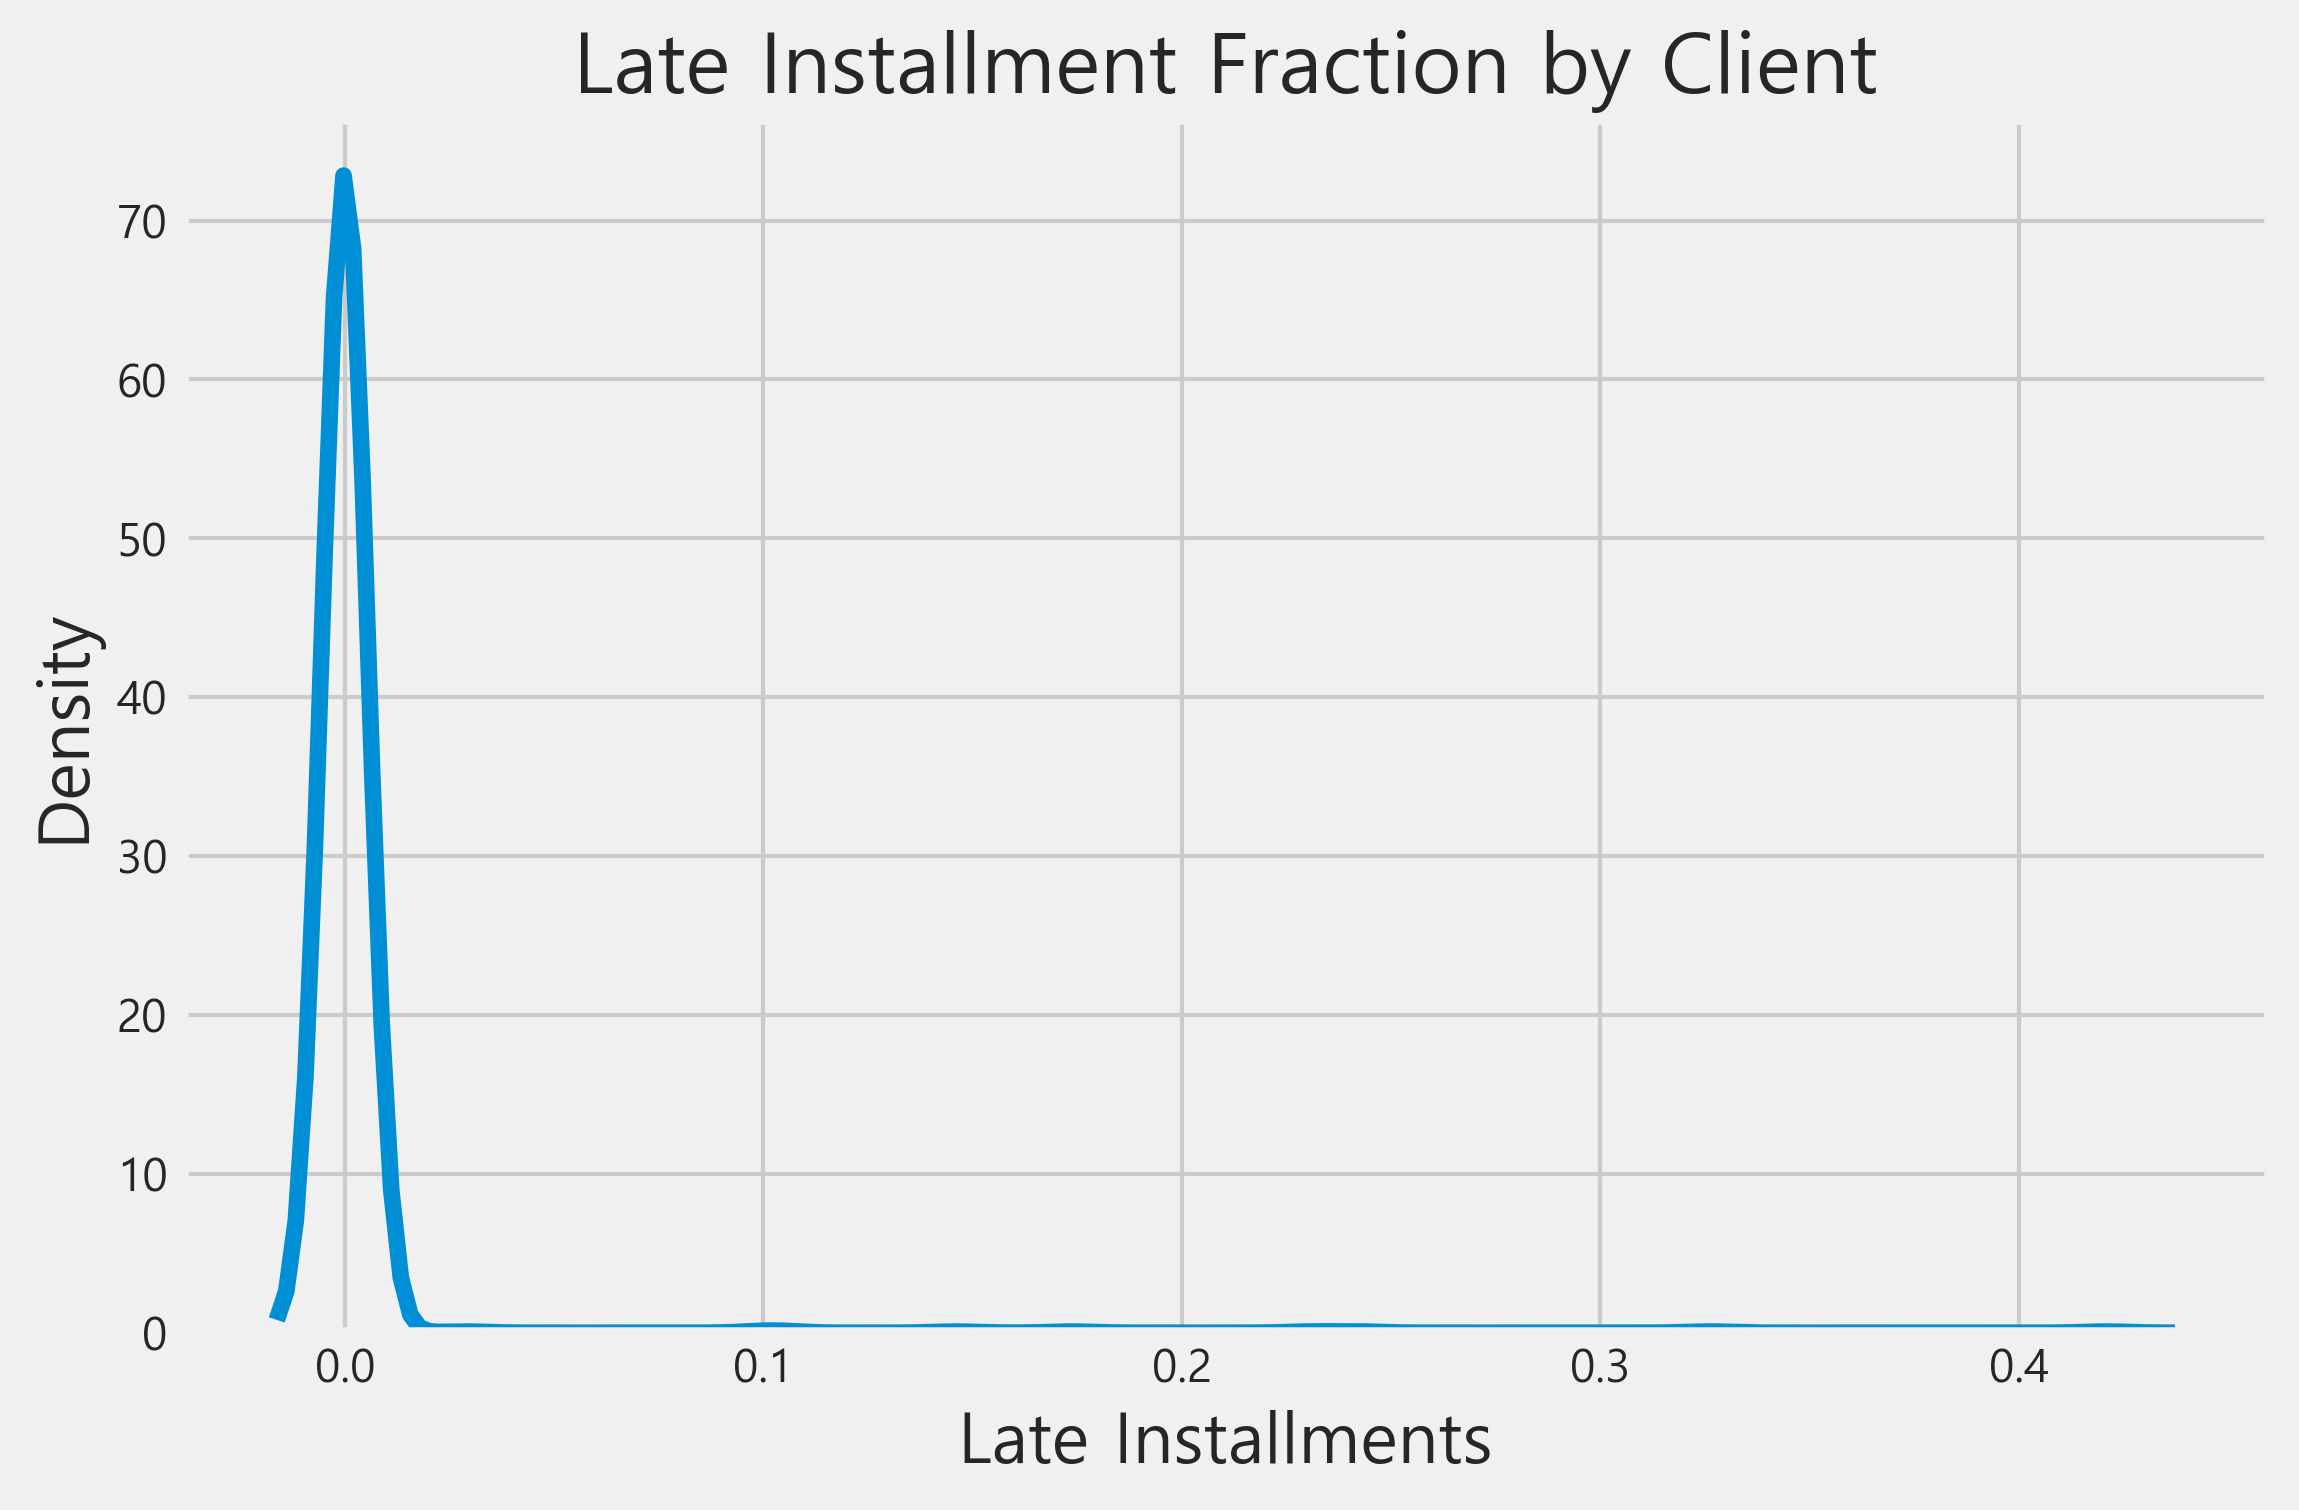

In [54]:
sns.kdeplot(seed_features['PERCENT_TRUE(installments.late_payment)'].dropna(), label = '')
plt.xlabel('Late Installments'); plt.ylabel('Density'); plt.title('Late Installment Fraction by Client')

우리가 사용할 수 있는 또 다른 seed feature는 다른 기관의 이전 대출이 연체되었는지 여부입니다.

In [57]:
past_due = ft.Feature(es['bureau_balance']['STATUS']).isin(['1', '2', '3', '4', '5'])
past_due = past_due.rename("past_due")

In [2]:
import featuretools as ft
ft.__version__

'1.13.0'

In [58]:
seed_features, seed_feature_names = ft.dfs(entityset=es, target_dataframe_name="app_train",
                                           agg_primitives=["percent_true", "mean"],
                                           trans_primitives=[],
                                           seed_features=[past_due], verbose=True,
                                           chunk_size=len(app_train),
                                           ignore_dataframes=["app_test"])

Built 243 features
Elapsed: 00:00 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


# Create Custom Feature Primitives
featuretools의 기존 primitives에 만족하지 않으면 직접 작성할 수 있습니다. 이는 featuretools의 기능을 확장할 수 있는 매우 강력한 방법입니다.


**feturetools 버전 업데이트로 인해 없어진 라이브러리 등이 많아 이 또한 생략합니다.**

# Putting it all Together
마지막으로 time variables, 올바르게 지정된 categorical variables, interesting features, seed features 및 custom features를 사용하여 deep feature synthesis를 실행할 수 있습니다. 전체 데이터 세트에서 실제로 실행하려면 여기에서 코드를 가져와 스크립트에 넣은 다음 더 많은 computational resourves를 사용할 수 있습니다.

In [68]:
feature_matrix, feature_names = ft.dfs(entityset=es, target_dataframe_name='app_train',
                                       agg_primitives=['mean', 'max', 'min', 'mode', 'count', 
                                                       'sum', 'percent_true'],
                                       trans_primitives=['diff', 'cum_sum', 'cum_mean', 'percentile'], 
                                       where_primitives=['mean', 'sum'],
                                       seed_features=[late_payment, past_due],
                                       max_depth=2, verbose=True,
                                       chunk_size=len(app_train),
                                       ignore_dataframes=['app_test'])

Built 2383 features
Elapsed: 00:04 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


이제 테스트 세트에 적용된 동일한 작업을 수행합니다. 별도로 계산을 수행하면 테스트 데이터에서 훈련 데이터로 누출되는 것을 방지할 수 있습니다.

In [69]:
feature_matrix_test, feature_names_test = ft.dfs(entityset=es, target_dataframe_name='app_test',
                                                 agg_primitives=['mean', 'max', 'min', 'mode', 'count', 'sum', 'percent_true'],
                                                 trans_primitives=['diff', 'cum_sum', 'cum_mean', 'percentile'], 
                                                 where_primitives=['mean', 'sum'],
                                                 seed_features=[late_payment, past_due],
                                                 max_depth=2, verbose=True,
                                                 chunk_size=len(app_test),
                                                 ignore_dataframes=['app_train'])

Built 2382 features
Elapsed: 00:03 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [70]:
import random
random.sample(feature_names, 10)

[<Feature: PERCENTILE(MIN(installments.AMT_INSTALMENT))>,
 <Feature: DIFF(COUNT(installments))>,
 <Feature: PERCENTILE(MAX(previous.RATE_DOWN_PAYMENT))>,
 <Feature: SUM(credit.CNT_DRAWINGS_ATM_CURRENT)>,
 <Feature: CUM_SUM(AMT_GOODS_PRICE)>,
 <Feature: MEAN(previous.SUM(cash.SK_DPD))>,
 <Feature: MIN(previous.PERCENTILE(AMT_CREDIT))>,
 <Feature: MAX(cash.previous.AMT_ANNUITY)>,
 <Feature: PERCENTILE(MAX(credit.SK_DPD))>,
 <Feature: MEAN(previous.SUM(credit.AMT_DRAWINGS_OTHER_CURRENT))>]

## Remove Features
feature selection은 그 자체로 전체 토픽이 될 수 있습니다. 하지만, 우리가 할 수 있는 한 가지는 내장된 featuretools selection function을 사용하여 unique 값이 하나만 있거나 모든 값이 null인 칼럼을 제거하는 것입니다.

In [71]:
from featuretools import selection

feature_matrix2 = selection.remove_low_information_features(feature_matrix)
print('Removed %d features from training features'  % (feature_matrix.shape[1] - feature_matrix2.shape[1]))

feature_matrix_test2 = selection.remove_low_information_features(feature_matrix_test)
print('Removed %d features from testing features' % (feature_matrix_test.shape[1] - feature_matrix_test2.shape[1]))

Removed 128 features from training features
Removed 168 features from testing features


작업이 끝나면 결과를 csv에 저장하고 싶을 것입니다. 데이터 프레임의 인덱스는 identifying column이므로 인덱스를 유지해야 합니다. 또한, 동일한 칼럼을 갖도록 훈련 및 테스트 데이터 프레임을 align해야 합니다.

In [72]:
train_labels = feature_matrix['TARGET']
feature_matrix, feature_matrix_test = feature_matrix2.align(feature_matrix_test2, join='inner', axis=1)
feature_matrix['TARGET'] = train_labels

print('Final training shape: ', feature_matrix.shape)
print('Final testing shape: ', feature_matrix_test.shape)

Final training shape:  (1001, 2215)
Final testing shape:  (1001, 2214)


In [73]:
feature_matrix.to_csv('feature_matrix.csv')
feature_matrix_test.to_csv('feature_matrix_test.csv')

# Conclusions
우리는 위의 방법을 사용하여 문제에 대한 도메인 지식을 우리의 features로 인코딩하거나 다른 사람들이 유용하다고 알아낸 것을 기반으로 features를 만들 수 있습니다. 여기서부터 다음 단계는 전체 데이터 세트에서 스크립트를 실행한 다음 모델링에 features을 사용하는 것입니다. 모델의 feature importances를 사용하여 가장 관련성이 높은 features를 결정하고, feature selection을 수행한 다음, 새로운 primitives, seed features, interesting features를 사용하여 또 다른 feature synthesis를 수행할 수 있습니다. machine learning의 많은 측면과 마찬가지로, feature creation은 대체로 경험적이고 반복적인 절차입니다.